# PUBG Players Finishing Placement Prediction

## DESCRIPTION

Create a model that predicts players’ finishing placement based on their final stats, on a scale of 1 (first place) to 0 (last place). 

## Problem Statement:  

PlayerUnknown’s BattleGrounds (PUBG) has enjoyed massive popularity. With over 50 million copies sold, it’s the fifth best-selling game of all time and has millions of active monthly players.

You are provided with a large number of anonymous PUBG game stats, formatted so that each row contains one player’s post-game stats. The data comes from matches of all types, i.e., solos, duos, squads, and custom. There is no guarantee of having 100 players per match, or at the most 4 players per group. In the game, a player can find and use a variety of weapons, items, and vehicles. Players must also avoid the shrinking “circle”, which pushes players closer together on the map. 

## Domain:

Gaming

## Analysis to be done:

Perform data preprocessing, build a deep learning prediction model. 

## Content: 

### Dataset columns and definition:

* DBNOs - Number of enemy players knocked.

* assists - Number of enemy players this player damaged that were killed by teammates.

* boosts - Number of boost items used.

* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

* headshotKills - Number of enemy players killed with headshots.

* heals - Number of healing items used.

* Id - Player’s Id

* killPlace - Ranking in match of number of enemy players killed.

* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

* killStreaks - Max number of enemy players killed in a short amount of time.

* kills - Number of enemy players killed.

* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

* matchDuration - Duration of match in seconds.

* matchId - ID to identify match. There are no matches that are in both the training and testing set.

* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

* rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

* revives - Number of times this player revived teammates.

* rideDistance - Total distance traveled in vehicles measured in meters.

* roadKills - Number of kills while in a vehicle.

* swimDistance - Total distance traveled by swimming measured in meters.

* teamKills - Number of times this player killed a teammate.

* vehicleDestroys - Number of vehicles destroyed.

* walkDistance - Total distance traveled on foot measured in meters.

* weaponsAcquired - Number of weapons picked up.

* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

* numGroups - Number of groups we have data for in the match.

* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match

 
## Steps to perform:

Perform exploration of the data and apply feature engineering on the data. Follow up with a deep learning model to predict players finishing placement.

### Tasks:

* Data Exploration:

    * Check mean, quantile, and max kills

    * Draw inference by plotting kill counts

    * Check signs of cheating

* Feature Engineering:

    * Creating new features from existing to depict data in a better way

    * Expressing relative rank instead of absolute in the form of percentage

    * Dropping redundant features

    * Dropping cheaters

    * Grouping and aggregating features

* Model Creation:

    * Create a sequential model with Keras using Tensorflow backend

    * Take four dense layers, three dropout layers, three batch normalizations, and use PreLu as an activation function

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
%matplotlib inline 
pd.options.display.max_columns = None
sns.set_style("whitegrid")
plt.style.use("seaborn-whitegrid")

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train_path = "./gdrive/MyDrive/datasets/PUBG_Finish_Placement_Prediction/train_V2.csv"
test_path = "./gdrive/MyDrive/datasets/PUBG_Finish_Placement_Prediction/test_V2.csv"

# Loading Dataset

In [5]:
df = pd.read_csv(
    filepath_or_buffer=train_path,
    index_col=["Id", "groupId", "matchId"],
    dtype={
        "assists": "int8",
        "boosts": "int8",
        "damageDealt": "float16",
        "DBNOs": "int8",
        "headshotKills": "int8",
        "heals": "int8",
        "killPlace": "int8",
        "killPoints": "int16",
        "kills": "int8",
        "killStreaks": "int8",
        "longestKill": "float16",
        "matchDuration": "int16",
        "matchType": "category",
        "maxPlace": "int8",
        "numGroups": "int8",
        "rankPoints": "int16",
        "revives": "int8",
        "rideDistance": "float16",
        "roadKills": "int8",
        "swimDistance": "float16",
        "teamKills": "int8",
        "vehicleDestroys": "int8",
        "walkDistance": "float16",
        "weaponsAcquired": "int16",
        "winPoints": "int16"
    }
)
df.head()

,,,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
Id,groupId,matchId,,,,,,,,,,,,,,,,,,,,,,,,,,
7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,squad-fpp,28,26,-1,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.4444
eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,squad-fpp,26,25,1484,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.6400
1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,duo,50,47,1491,0,0.000000,0,0.000000,0,0,161.75,2,0,0.7755
4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,squad-fpp,31,30,1408,0,0.000000,0,0.000000,0,0,202.75,3,0,0.1667
315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,solo-fpp,97,95,1560,0,0.000000,0,0.000000,0,0,49.75,2,0,0.1875


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4446966 entries, ('7f96b2f878858a', '4d4b580de459be', 'a10357fd1a4a91') to ('0d8e7ed728b6fd', '8c74f72fedf5ff', '62a16aabcc095c')
Data columns (total 26 columns):
 #   Column           Dtype   
---  ------           -----   
 0   assists          int8    
 1   boosts           int8    
 2   damageDealt      float16 
 3   DBNOs            int8    
 4   headshotKills    int8    
 5   heals            int8    
 6   killPlace        int8    
 7   killPoints       int16   
 8   kills            int8    
 9   killStreaks      int8    
 10  longestKill      float16 
 11  matchDuration    int16   
 12  matchType        category
 13  maxPlace         int8    
 14  numGroups        int8    
 15  rankPoints       int16   
 16  revives          int8    
 17  rideDistance     float16 
 18  roadKills        int8    
 19  swimDistance     float16 
 20  teamKills        int8    
 21  vehicleDestroys  int8    
 22  walkDistance     float16 
 23  weapons

# Data Cleaning

In [7]:
df.dropna(inplace=True)
df.drop(columns=["killPoints", "rankPoints", "winPoints"], inplace=True) #deprecated features

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4446965 entries, ('7f96b2f878858a', '4d4b580de459be', 'a10357fd1a4a91') to ('0d8e7ed728b6fd', '8c74f72fedf5ff', '62a16aabcc095c')
Data columns (total 23 columns):
 #   Column           Dtype   
---  ------           -----   
 0   assists          int8    
 1   boosts           int8    
 2   damageDealt      float16 
 3   DBNOs            int8    
 4   headshotKills    int8    
 5   heals            int8    
 6   killPlace        int8    
 7   kills            int8    
 8   killStreaks      int8    
 9   longestKill      float16 
 10  matchDuration    int16   
 11  matchType        category
 12  maxPlace         int8    
 13  numGroups        int8    
 14  revives          int8    
 15  rideDistance     float16 
 16  roadKills        int8    
 17  swimDistance     float16 
 18  teamKills        int8    
 19  vehicleDestroys  int8    
 20  walkDistance     float16 
 21  weaponsAcquired  int16   
 22  winPlacePerc     float64 
dtypes: cate

# Data Exploration:

* Check mean, quantile, and max kills

* Draw inference by plotting kill counts

* Check signs of cheating

In [9]:
df["kills"].astype('float64').agg(["mean", "median", "max"])

mean       0.924784
median     0.000000
max       72.000000
Name: kills, dtype: float64

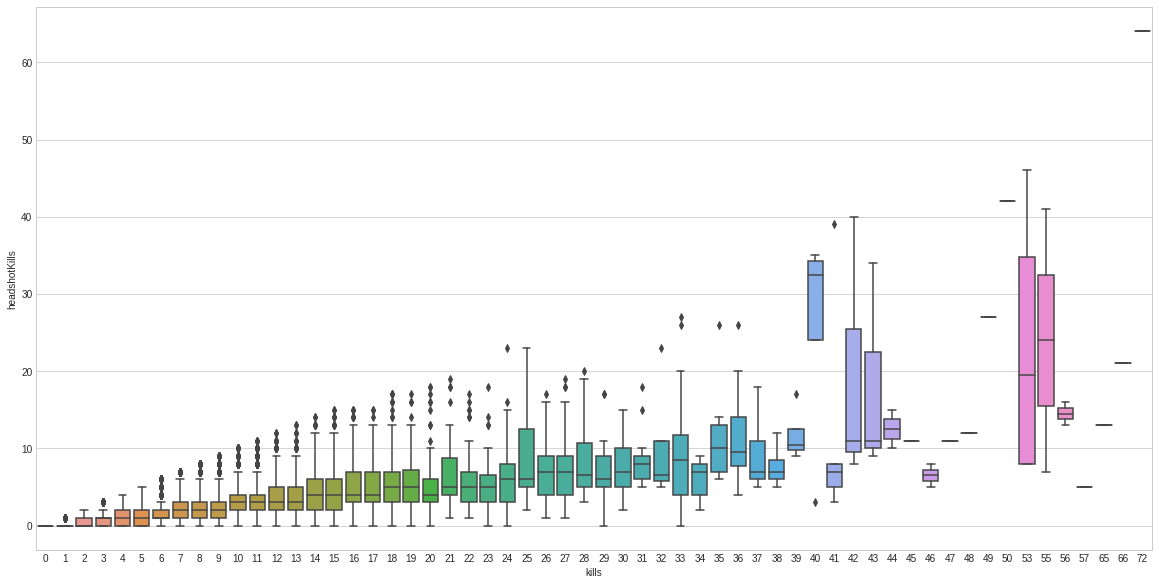

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df, x="kills", y="headshotKills", ax=ax)
plt.show()

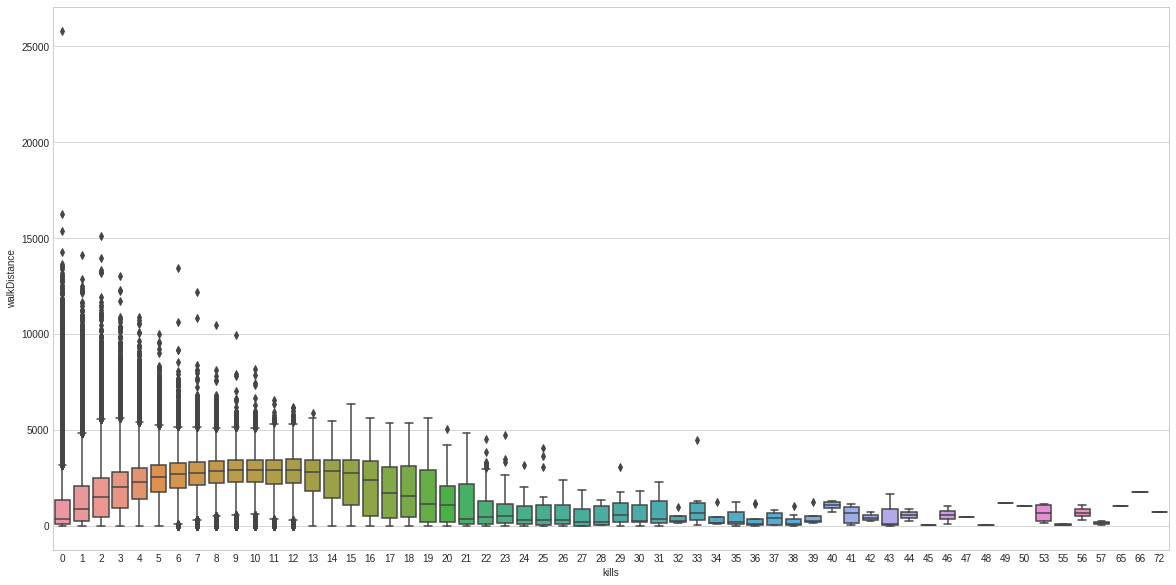

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df, x="kills", y="walkDistance", ax=ax)
plt.show()

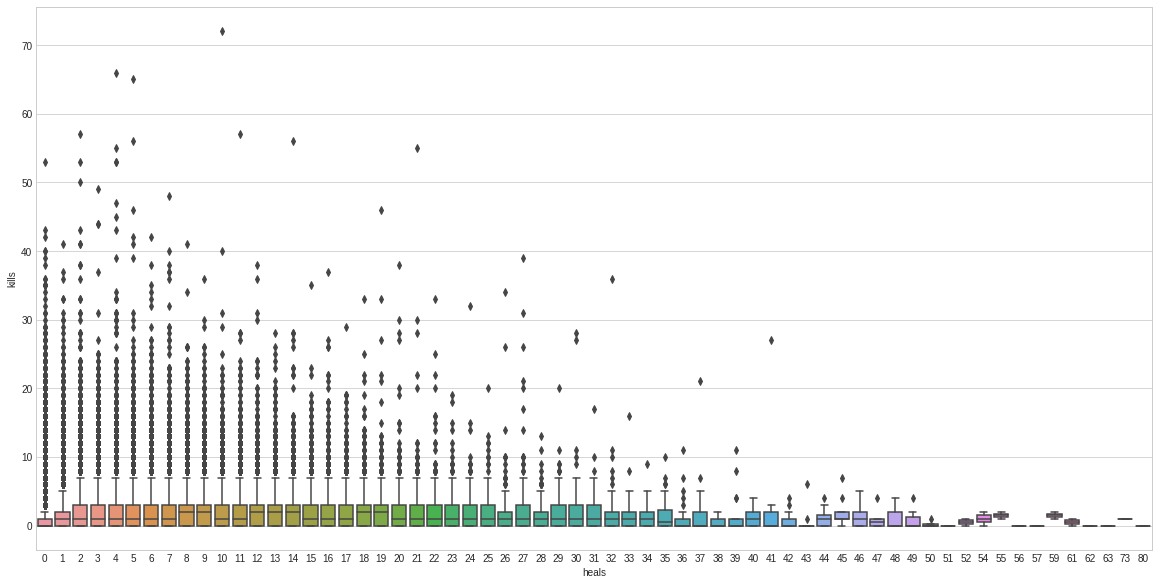

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df, x="heals", y="kills", ax=ax)
plt.show()

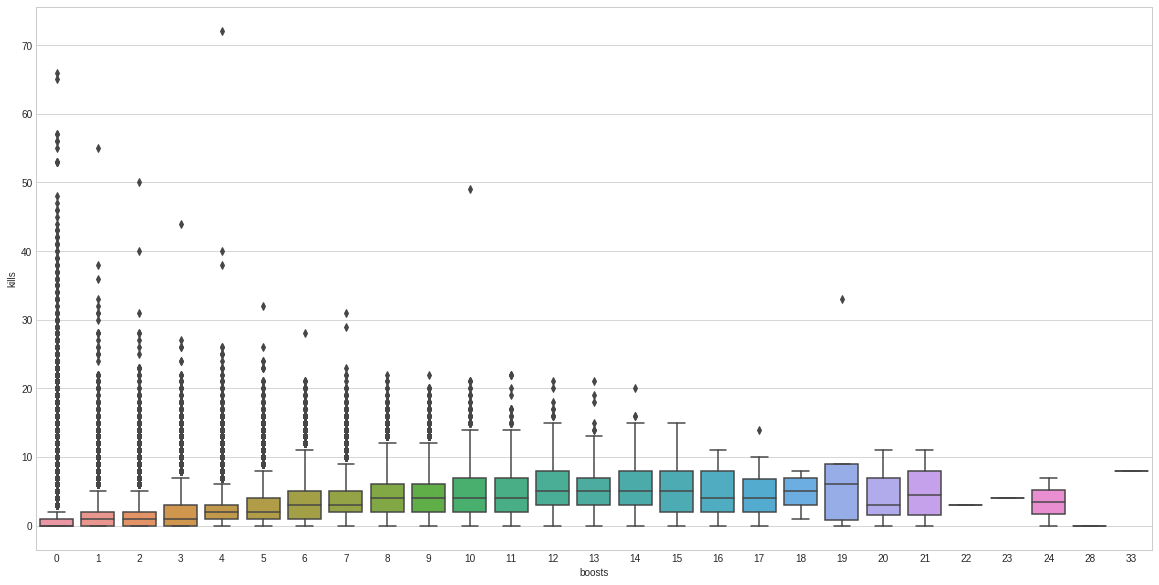

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df, x="boosts", y="kills", ax=ax)
plt.show()

### Cheater signs:

Cheaters usually is some players that win the game and has a far outliers stats. the following sign usually appears in a cheaters:

1. win the match

2. High kills & High headshot kills

3. High kills/meter rate

4. High kills/s 

5. High kills without using boosts and heals

6. High kills and no damage dealt

7. High weapon acquired/m ratio

8. High weapon acquired/s

9. High kills and without DBNOs

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
def get_outliers(x, k=1.5, upper_edge=True, lower_edge=True):

    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    cut_off = k * iqr

    lower, upper = q1 - cut_off, q3 + cut_off

    if upper_edge and lower_edge:
        cond = (x < lower) | (x > upper)
    elif upper_edge:
        cond = (x > upper)
    elif lower_edge:
        cond = (x < lower)
    else:
        return x

    outlier = x.where(cond=cond, other=0.0)
 
    return outlier

In [16]:
def get_cheaters(df, k=5):
    
    # get the winners

    winners_df = df[df["winPlacePerc"] == 1.0].copy()

    # feature extractions

    winners_df["totalDistance"] = winners_df["walkDistance"] + winners_df["rideDistance"] + winners_df["swimDistance"]
    
    winners_df["boostsHeals"] = winners_df["boosts"] + winners_df["heals"]

    winners_df["headshotPerKill"] = winners_df["headshotKills"].astype('float64') / winners_df["kills"]

    winners_df["killPerMeter"] = winners_df["kills"].astype('float64') / (winners_df["totalDistance"] + 0.01)

    winners_df["killPerSecond"] = winners_df["kills"].astype('float64') / winners_df["matchDuration"]

    winners_df["boostsHealsPerKill"] = winners_df["boostsHeals"].astype('float64') / (winners_df["kills"] + 1)

    winners_df["damagePerKill"] = winners_df["damageDealt"].astype('float64') / (winners_df["kills"] + 1)

    winners_df["DBNOsPerKills"] = winners_df["DBNOs"].astype('float64') / (winners_df["kills"])

    winners_df["weaponPerMeter"] = winners_df["weaponsAcquired"].astype('float64') / (winners_df["totalDistance"] + 0.01)

    winners_df["weaponPerSecond"] = winners_df["weaponsAcquired"].astype('float64') / winners_df["matchDuration"]

    # drop irrelevant features & fill -inf, +inf, nan

    winners_df.replace({
        np.nan: 0,
        np.Inf: 0,
        np.NINF: 0}, inplace=True)

    winners_df.drop(columns=["assists", 
                             "boosts",
                             "heals",
                             "killPlace",
                             "matchType",
                             "maxPlace",
                             "numGroups",
                             "revives",
                             "rideDistance",
                             "roadKills",
                             "swimDistance",
                             "teamKills",
                             "vehicleDestroys",
                             "walkDistance",
                             "winPlacePerc"
                             ], inplace=True)
    
    conditions = {
        "damageDealt": lambda x: get_outliers(x, k=k, upper_edge=False),
        "DBNOs": lambda x: get_outliers(x, k=k, upper_edge=False),
        "headshotKills": lambda x: get_outliers(x, k=k, lower_edge=False),
        "kills": lambda x: get_outliers(x, k=k, lower_edge=False),
        "killStreaks": lambda x: get_outliers(x, k=k, lower_edge=False),
        "longestKill": lambda x: get_outliers(x, k=k, lower_edge=False),
        "matchDuration": lambda x: get_outliers(x, k=k, upper_edge=False),
        "weaponsAcquired": lambda x: get_outliers(x, k=k, lower_edge=False),
        "totalDistance": lambda x: get_outliers(x, k=k, upper_edge=False),
        "boostsHeals": lambda x: get_outliers(x, k=k),
        "headshotPerKill": lambda x: get_outliers(x, k=k, lower_edge=False),
        "killPerMeter": lambda x: get_outliers(x, k=k, lower_edge=False),
        "killPerSecond": lambda x: get_outliers(x, k=k, lower_edge=False),
        "boostsHealsPerKill": lambda x: get_outliers(x, k=k),
        "damagePerKill": lambda x: get_outliers(x, k=k, upper_edge=False),
        "DBNOsPerKills": lambda x: get_outliers(x, k=k, upper_edge=False),
        "weaponPerMeter": lambda x: get_outliers(x, k=k, lower_edge=False),
        "weaponPerSecond": lambda x: get_outliers(x, k=k, lower_edge=False),
    }

    # scale datasets

    scaler = StandardScaler()
    z = pd.DataFrame(data=scaler.fit_transform(winners_df),
                     columns=winners_df.columns,
                     index=winners_df.index)

    # get outliers scores

    outliers = pd.DataFrame()

    for col, func in conditions.items():
        outliers[col] = func(z[col])

    # drop normal records

    outliers.drop(index=outliers[(outliers == 0.0).all(axis=1)].index, inplace=True)

    outliers["points"] = outliers.sum(axis=1)

    return outliers["points"]

In [17]:
outliers = get_cheaters(df, k=10)
outliers.head()

Id              groupId         matchId       
ce39351ac31340  0edc46edf214ea  f001fa89bd6db3   -0.026104
89120d2f4e44e0  fa54efeb11b8a6  662c9c7f9e87d0    8.049696
f485c54e3c9652  43b9495099889d  1f78e2436506db   -0.063056
3fc123559fc935  5cef1df7ee3551  01aead02bb8901    2.937742
106afdb574db25  4b0ae4659e9936  cf0cb51c829eb5    0.936853
Name: points, dtype: float64

In [18]:
q1 = outliers.quantile(0.25)
q3 = outliers.quantile(0.75)
irq = q3 - q1
k = 5
cut_off = irq * k

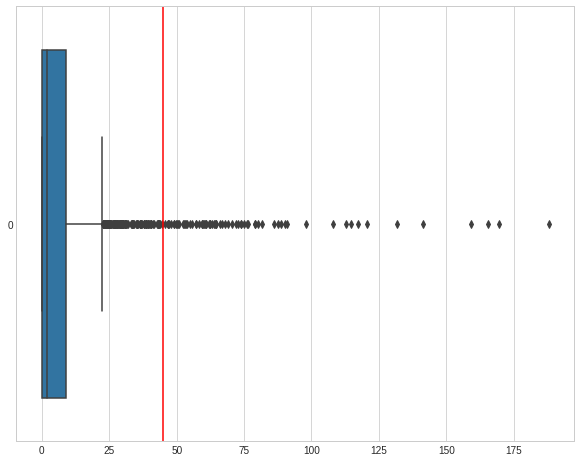

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=outliers, orient="h", ax=ax)
ax.axvline(x=cut_off, c="r")

In [20]:
ids = outliers[outliers > cut_off].index
df.loc[ids, :].sort_values(by=["kills"], ascending=False)

,,,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
Id,groupId,matchId,,,,,,,,,,,,,,,,,,,,,,,
06308c988bf0c2,4c4ee1e9eb8b5e,6680c7c3d17d48,7,4,5992.0,0,64,10,1,72,7,78.25000,1800,normal-squad,15,15,0,0.0,0,0.0,0,0,728.000000,35,1.0
80ac0bbf58bfaf,1e54ab4540a337,08e4c9e6c033e2,5,0,6376.0,0,21,4,1,66,8,320.00000,1390,normal-solo-fpp,18,12,0,0.0,0,0.0,0,0,1740.000000,23,1.0
810f2379261545,7f3e493ee71534,f900de1ec39fa5,20,0,6616.0,0,13,5,1,65,7,73.87500,1798,normal-solo-fpp,11,11,0,0.0,0,0.0,0,0,1036.000000,60,1.0
da31f191ace8ed,ce9a3c4950a8f2,17dea22cefe62a,10,0,5792.0,0,5,2,1,57,5,104.18750,1798,normal-duo-fpp,15,12,0,0.0,0,0.0,0,0,24.265625,56,1.0
7f3edd982813e6,10a20932a5cf8f,cfa2775c9ef944,6,0,5408.0,0,16,14,1,56,5,95.50000,1797,normal-solo-fpp,37,22,0,0.0,0,0.0,0,0,287.500000,50,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6cc9d7b1643cbd,11fce60d5c8ea3,60c6e90b964266,3,0,645.5,6,1,0,28,5,2,57.59375,1216,normal-squad-fpp,6,6,2,0.0,0,0.0,0,0,0.000000,31,1.0
fedf03626cf9f2,11d036be4e05e5,ab1308cd283e8a,1,4,683.5,5,0,8,3,4,1,37.81250,1956,squad-fpp,29,29,2,450.5,0,0.0,0,0,3084.000000,85,1.0
ba886401c5bcd4,6ec37510f1b86b,313c9787226bbe,5,0,632.0,3,0,0,47,4,1,46.28125,1198,normal-squad-fpp,7,7,0,0.0,0,0.0,0,0,0.000000,39,1.0


# Feature Engineering:

* Creating new features from existing to depict data in a better way 

* Expressing relative rank instead of absolute in the form of percentage 
    
* Dropping redundant features 

* Dropping cheaters 

* Grouping and aggregating features

In [21]:
df["totalDistance"] = df["walkDistance"] + df["rideDistance"] + df["swimDistance"]
df["totalHeals"] = df["heals"] + df["boosts"]

In [22]:
numPlayers = df.groupby(level=["matchId", "groupId"]).size()
numPlayers.name = "numPlayers"

totalPlayers = df.groupby(level=["matchId"]).size()
totalPlayers.name = "totalPlayers"

In [23]:
df = pd.merge(left=df.reset_index(),
         right=numPlayers.reset_index(),
         on=["matchId", "groupId"]).set_index(["Id", "groupId", "matchId"])

In [24]:
df = pd.merge(left=df.reset_index(),
         right=totalPlayers.reset_index(),
         on=["matchId"]).set_index(["Id", "groupId", "matchId"])

In [25]:
df["totalDistance"] = df["totalDistance"].astype("float64")

In [26]:
df.head()

,,,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,totalDistance,totalHeals,numPlayers,totalPlayers
Id,groupId,matchId,,,,,,,,,,,,,,,,,,,,,,,,,,,
7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,0,0,0.00000,1306,squad-fpp,28,26,0,0.0,0,0.0,0,0,244.75000,1,0.4444,244.75000,0,4,96
7516514fbd1091,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,62,0,0,0.00000,1306,squad-fpp,28,26,0,0.0,0,0.0,0,0,48.28125,1,0.4444,48.28125,0,4,96
c56d45be16aa86,4d4b580de459be,a10357fd1a4a91,0,0,318.00,2,1,0,6,4,1,27.65625,1306,squad-fpp,28,26,0,0.0,0,0.0,0,0,342.75000,2,0.4444,342.75000,0,4,96
100eef17c4d773,4d4b580de459be,a10357fd1a4a91,0,0,90.75,0,0,0,61,0,0,0.00000,1306,squad-fpp,28,26,0,0.0,0,0.0,0,0,96.06250,1,0.4444,96.06250,0,4,96
09824fabf2cdc0,7e5fb71e05a678,a10357fd1a4a91,1,1,335.50,3,1,1,29,1,1,63.65625,1306,squad-fpp,28,26,0,0.0,0,0.0,1,0,2136.00000,7,0.8148,2136.00000,2,4,96


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4446965 entries, ('7f96b2f878858a', '4d4b580de459be', 'a10357fd1a4a91') to ('d4f2672719bfcd', '4e4a3667af2b83', 'fcad6c3fdd847a')
Data columns (total 27 columns):
 #   Column           Dtype   
---  ------           -----   
 0   assists          int8    
 1   boosts           int8    
 2   damageDealt      float16 
 3   DBNOs            int8    
 4   headshotKills    int8    
 5   heals            int8    
 6   killPlace        int8    
 7   kills            int8    
 8   killStreaks      int8    
 9   longestKill      float16 
 10  matchDuration    int16   
 11  matchType        category
 12  maxPlace         int8    
 13  numGroups        int8    
 14  revives          int8    
 15  rideDistance     float16 
 16  roadKills        int8    
 17  swimDistance     float16 
 18  teamKills        int8    
 19  vehicleDestroys  int8    
 20  walkDistance     float16 
 21  weaponsAcquired  int16   
 22  winPlacePerc     float64 
 23  totalDi

In [28]:
groups_df = df.groupby(level=["matchId", "groupId"]).agg({
    "assists": "sum",
    "damageDealt": "sum",
    "DBNOs": "sum",
    "headshotKills": "sum",
    "kills": "sum",
    "roadKills": "sum",
    "killStreaks": "max",
    "longestKill": "max",
    "matchDuration": "first",
    "matchType": "first",
    "numGroups": "first",
    "revives": "sum",
    "teamKills": "sum",
    "vehicleDestroys": "sum",
    "weaponsAcquired": "sum",
    "totalDistance": "sum",
    "totalHeals": "sum",
    "numPlayers": "first",
    "totalPlayers": "first",
    "winPlacePerc": "first",
    })

In [29]:
groups_df["numEnemys"] = groups_df["totalPlayers"] - groups_df["numPlayers"]

In [30]:
for col in ["assists", "DBNOs", "headshotKills", "kills", "roadKills"]:
    groups_df[col] = groups_df[col] * (groups_df["numEnemys"].astype("float64") / groups_df["numPlayers"])

for col in ["teamKills", "revives", "weaponsAcquired", "totalDistance", "totalHeals", "damageDealt", "vehicleDestroys"]:
    groups_df[col] = groups_df[col].astype("float64") / groups_df["numPlayers"].astype("float64")

groups_df.drop(columns=["numGroups", "totalPlayers", "matchType"], inplace=True)

groups_df.head()

assists  damageDealt       DBNOs  \
matchId        groupId                                            
0000a43bce5eec 18b16ec699d8b6      0.0   109.687500   93.000000   
               236ab9e9c081b9      0.0    48.000000   29.666667   
               3a6addfa0df938      0.0     0.000000    0.000000   
               4bf06994bd4c9a      0.0    11.703125    0.000000   
               4d1bbbc19b9084     93.0   341.000000  232.500000   

                               headshotKills  kills  roadKills  killStreaks  \
matchId        groupId                                                        
0000a43bce5eec 18b16ec699d8b6            0.0   93.0        0.0            1   
               236ab9e9c081b9            0.0    0.0        0.0            0   
               3a6addfa0df938            0.0    0.0        0.0            0   
               4bf06994bd4c9a            0.0    0.0        0.0            0   
               4d1bbbc19b9084           93.0  279.0        0.0            2   

                               longestKill  matchDuration  revives  teamKills  \
matchId        groupId                                                          
0000a43bce5eec 18b16ec699d8b6    12.546875           1346      0.0        0.0   
               236ab9e9c081b9     0.000000           1346      0.0        0.0   
               3a6addfa0df938     0.000000           1346      0.0        0.0   
               4bf06994bd4c9a     0.000000           1346      0.0        0.0   
               4d1bbbc19b9084    33.406250           1346      0.0        0.0   

                               vehicleDestroys  weaponsAcquired  \
matchId        groupId                                            
0000a43bce5eec 18b16ec699d8b6              0.0         1.000000   
               236ab9e9c081b9              0.0         0.833333   
               3a6addfa0df938              0.0         0.500000   
               4bf06994bd4c9a              0.0         7.000000   
               4d1bbbc19b9084              0.0         4.000000   

                               totalDistance  totalHeals  numPlayers  \
matchId        groupId                                                 
0000a43bce5eec 18b16ec699d8b6     131.687500         1.0           2   
               236ab9e9c081b9      19.931641         0.0           6   
               3a6addfa0df938       4.816406         0.0           2   
               4bf06994bd4c9a     559.125000         0.5           2   
               4d1bbbc19b9084    3378.000000         4.5           2   

                               winPlacePerc  numEnemys  
matchId        groupId                                  
0000a43bce5eec 18b16ec699d8b6        0.3333         93  
               236ab9e9c081b9        0.0370         89  
               3a6addfa0df938        0.0000         93  
               4bf06994bd4c9a        0.3704         93  
               4d1bbbc19b9084        1.0000         93

# Model Creation:

* Create a sequential model with Keras using Tensorflow backend

* Take four dense layers, three dropout layers, three batch normalizations, and use PreLu as an activation function

In [31]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, PReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
X = groups_df.drop(columns=["winPlacePerc"]).astype("float32").values
X = StandardScaler().fit_transform(X)
y = groups_df["winPlacePerc"].astype("float32").values

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [34]:
def createModel():

    model = Sequential()
    
    model.add(Dense(512, kernel_initializer='he_normal', input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(256, kernel_initializer='he_normal'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(128, kernel_initializer='he_normal'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(1, kernel_initializer='normal', activation="sigmoid"))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="mse",
                  metrics=["mae"]
                  )

    return model

In [35]:
model = createModel()
history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=10_000,
        verbose=2,
        validation_data=(X_test, y_test))

Epoch 1/20
142/142 - 68s - loss: 0.0159 - mae: 0.0961 - val_loss: 0.0145 - val_mae: 0.0913
Epoch 2/20
142/142 - 67s - loss: 0.0128 - mae: 0.0872 - val_loss: 0.0117 - val_mae: 0.0824
Epoch 3/20
142/142 - 67s - loss: 0.0123 - mae: 0.0853 - val_loss: 0.0113 - val_mae: 0.0815
Epoch 4/20
142/142 - 67s - loss: 0.0120 - mae: 0.0842 - val_loss: 0.0114 - val_mae: 0.0824
Epoch 5/20
142/142 - 67s - loss: 0.0117 - mae: 0.0832 - val_loss: 0.0112 - val_mae: 0.0816
Epoch 6/20
142/142 - 66s - loss: 0.0115 - mae: 0.0824 - val_loss: 0.0114 - val_mae: 0.0829
Epoch 7/20
142/142 - 67s - loss: 0.0114 - mae: 0.0818 - val_loss: 0.0112 - val_mae: 0.0820
Epoch 8/20
142/142 - 67s - loss: 0.0112 - mae: 0.0810 - val_loss: 0.0112 - val_mae: 0.0822
Epoch 9/20
142/142 - 67s - loss: 0.0111 - mae: 0.0804 - val_loss: 0.0109 - val_mae: 0.0806
Epoch 10/20
142/142 - 67s - loss: 0.0110 - mae: 0.0801 - val_loss: 0.0107 - val_mae: 0.0792
Epoch 11/20
142/142 - 66s - loss: 0.0110 - mae: 0.0799 - val_loss: 0.0106 - val_mae: 0.07

In [36]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

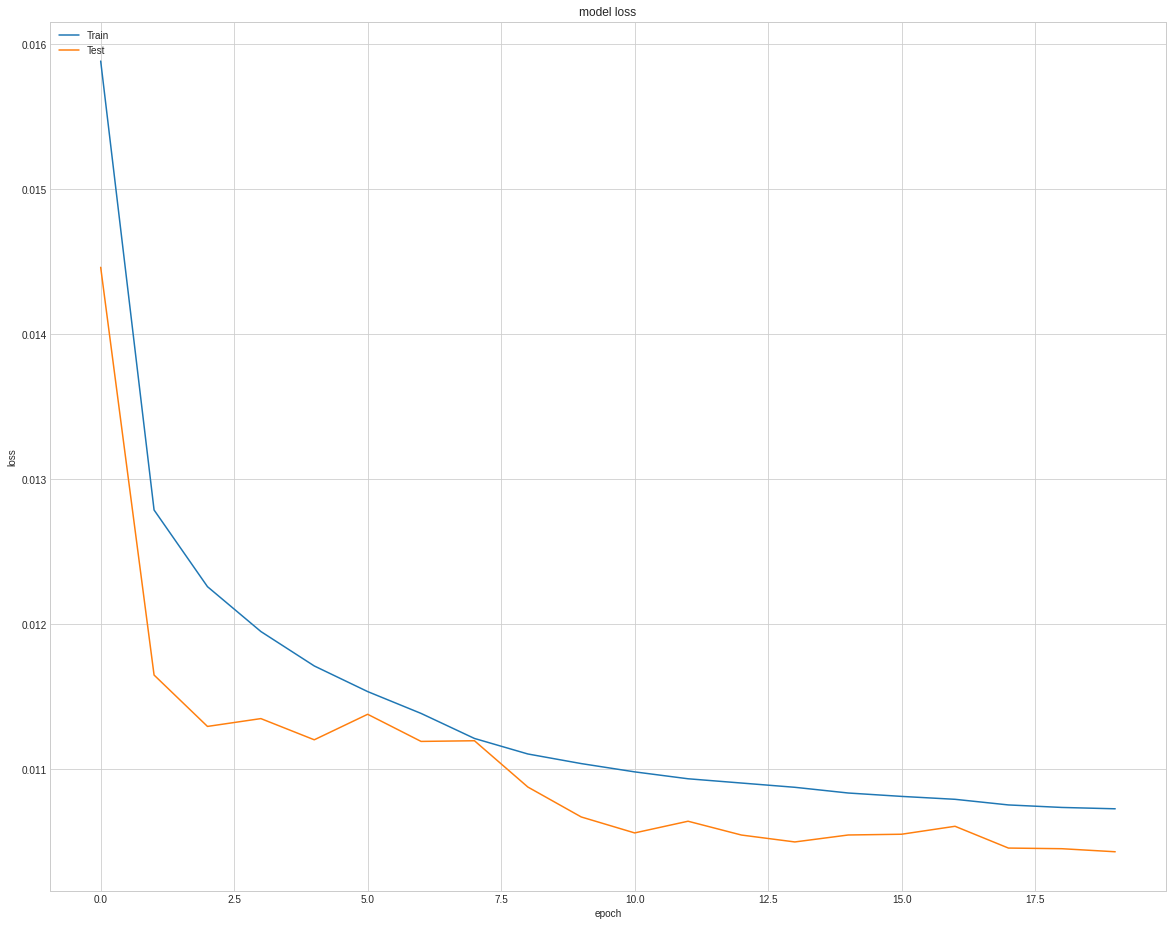

In [37]:
fig, ax = plt.subplots(figsize=(20, 16))

ax.plot(history.history["loss"])
ax.plot(history.history["val_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')

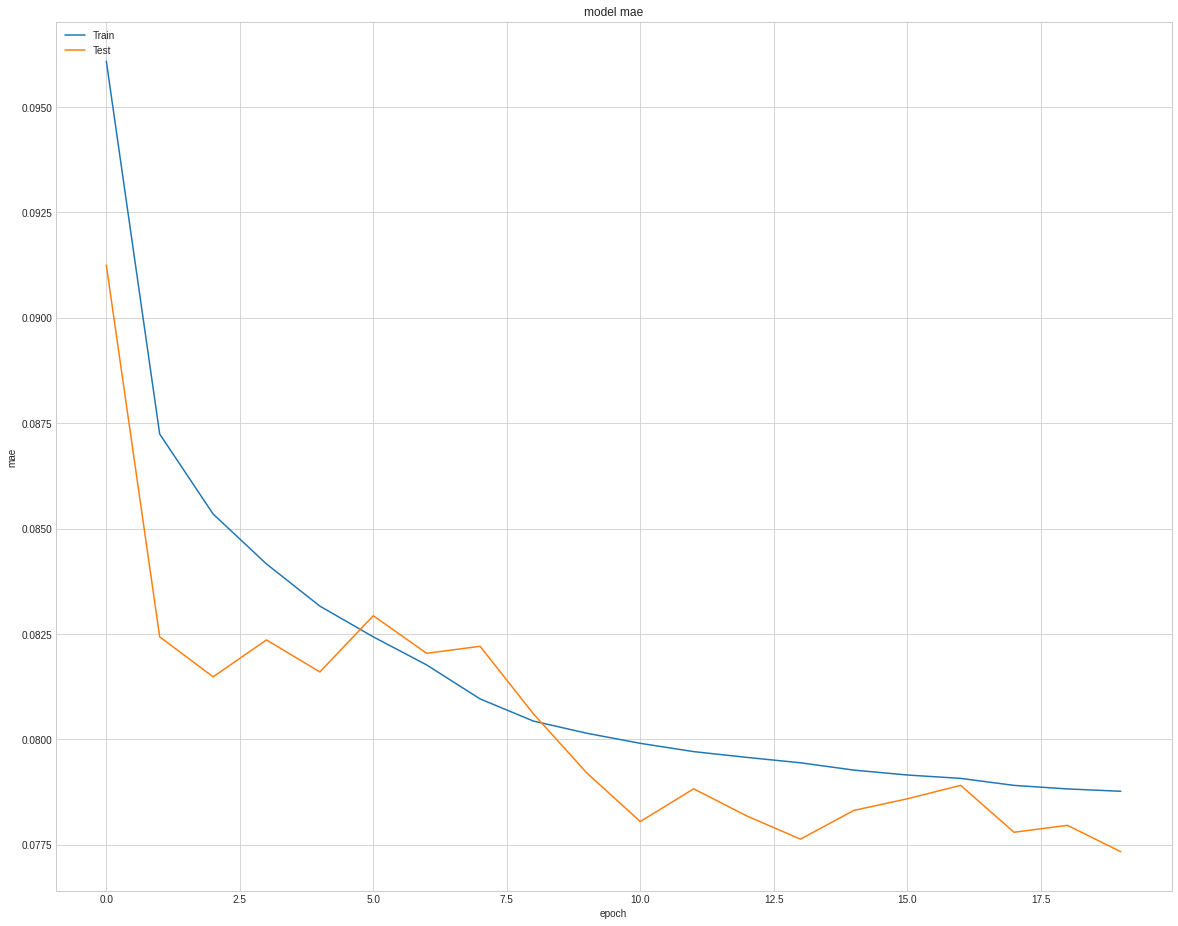

In [38]:
fig, ax = plt.subplots(figsize=(20, 16))

ax.plot(history.history["mae"])
ax.plot(history.history["val_mae"])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')